In [20]:
import json
import xml.etree.ElementTree as ET
from pathlib import Path

input_path = '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/metadata/'
simulation_setup = "lowCongestion_5minDemand"

config = json.load(open(input_path + "/config.json"))
config["NETWORK"] = Path(config["NETWORK"])
config["SUMO"] = Path(config["SUMO"])
# [CO] updated simulation setup to use OD scenario #4: 42-dimensional  + low congestion.
#sim_setup = json.load(open(input_path + "simulation_setups_co_gt.json"))
sim_setup = json.load(open(input_path + f"simulation_setups_{simulation_setup}.json"))


In [21]:
# excluding warmup period of 15min
# so you need to simulate for at least 15min now. 
warm_up_sec = 15*60 # duration in seconds

# duration, in seconds, of each edge simulation output statistics
# this value should be consistent with what is defined in additional.add.xml
edge_stats_freq = 300

In [23]:
## Main simulator function
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import torch

from pandas import DataFrame
from pathlib import Path


def run_sumo(config, sim_setup, prefix_input, prefix_output):
    od2trips_cmd = (
        #f"od2trips --no-step-log  --spread.uniform "
        f"od2trips  --spread.uniform "
        #Loads TAZ (districts)
        f"--taz-files {config['NETWORK']}/{sim_setup['taz']} " 
        # Loads O/D-matrix in tazRelation format fromFILE(s)
        f"--tazrelation-files {config['NETWORK']}/{sim_setup[f'{prefix_input}_od']} "
        # Writes trip definitions into FILE
        f"-o {config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml " 
    )

    # Run SUMO to generate outputs
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_output}_{sim_setup['prefix_sim_run']}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={config['NETWORK']/sim_setup['net']} "
        # Load routes descriptions from FILE(s)
        f"--routes={config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b {sim_setup['start_sim_sec']} -e {sim_setup['end_sim_sec']} "
        # Load further descriptions from FILE(s)
        f"--additional-files {config['NETWORK']/sim_setup['add']} "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {config['NETWORK']}/routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
    
    )
        # f"--seed {seed}"

    try:
        print(od2trips_cmd)
        os.system(od2trips_cmd)
    except:
        print("Unable to create trips file")
    else:
        print("###### Running SUMO #######")
        print(sumo_run)
        os.system(sumo_run)


def parse_loop_data_xml_to_pandas(config: dict,loop_file: dict) -> DataFrame: 
    """Read the Loop Detectors Data: Each SUMO run produces a file with the
    traffic counts. This function reads the corresponding traffic counts file
    averages across simulation replications
    
    """

    output_file =(config["NETWORK"] / "loopOutputs.csv")
    ## See output explanation:
    # https://sumo.dlr.de/docs/Simulation/Output/Lane-_or_Edge-based_Traffic_Measures.html#generated_output

    data2csv = (
        f"python {config['SUMO']}/tools/xml/xml2csv.py "
        f"{loop_file} "
        f"-o {output_file}"
        )
    
    os.system(data2csv)
    
    df_trips = pd.read_csv(output_file, sep=";", header=0)

    # edge flow in vehicles per hour
    ## edge speed is given in m/s
    ## edge_density is given in no. of vehicles/km

    df_trips['interval_nVehContrib'] = df_trips['edge_arrived'] + df_trips['edge_left']
    #df_trips['interval_nVehContrib'] = 3.6*df_trips['edge_speed']*df_trips['edge_density']


    #df_trips['EdgeID'] = df_trips['edge_id']

    # edge speed is given in m/s
    # computed only for edges that have departed flow
    df_trips['interval_harmonicMeanSpeed'] = df_trips[df_trips['interval_nVehContrib']>0]['edge_speed']
    
    # exclude warm-up period
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]

    # aggregate the rest of the time intervals
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]
    df_agg = df_trips.groupby(by=['edge_id'], as_index=False).agg(
        {'interval_nVehContrib':np.sum, 'interval_harmonicMeanSpeed':np.mean})


    return df_agg, df_trips



def compute_nrmse_counts_one_edge(df_true, df_simulated,GT_edge_id):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    # only consider GT_edge_id of interest
    df1 = df1[df1['edge_id']==GT_edge_id]

    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


def compute_nrmse_counts_all_edges(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN



def generate_od_xml(x, config, sim_setup):

    init_od_path = f"{config['NETWORK']}/{sim_setup['init_od']}"

    if Path(init_od_path).is_file():
        print("Reading:",init_od_path)
        tree = ET.parse(init_od_path)
        root = tree.getroot()

        for i,x in enumerate(x):
            root[0][i].attrib["count"] = str(np.round(x,4))
            
    file_name = f"{config['NETWORK']}/{sim_setup['current_od']}"
    print('Saving: '+file_name)
    tree.write(file_name)
## Find upper and lower bounds
import pandas as pd

def transform_od_xml_to_pandas(file_path_xml):

    tree = ET.parse(file_path_xml)
    root = tree.getroot()

    od_mat = []
    for taz_elem in root.iter('tazRelation'):
        od_mat.append([taz_elem.get('from'), taz_elem.get('to'), int(taz_elem.get('count'))])
    
    df_od = pd.DataFrame(od_mat, columns=['tazFrom', 'tazTo', 'tazCount'])

    return df_od

file_path_xml = str(config['NETWORK']) + "/" + sim_setup['gt_od']
df_gt = transform_od_xml_to_pandas(file_path_xml)

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = df_gt.shape[0]

bounds = torch.tensor([
    [ df_gt[ 'tazCount'].min() for _ in range(dim_od)],
    [ df_gt[ 'tazCount'].max() for _ in range(dim_od)]
], device=device, dtype=dtype) 

bounds


tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
         3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
         3., 3., 3., 3., 3., 3.]], dtype=torch.float64)

In [24]:
### Obtain ground-truth value
loop_stats_df_gt, _ = parse_loop_data_xml_to_pandas(
    config,
    loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gt_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"
)


In [25]:
import os
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize
from botorch.utils.transforms import normalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.models.transforms import Standardize


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Maintain the TuRBO state

https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf

TuRBO needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc.

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation.

Note: These settings assume that the domain has been scaled to [0,1]𝑑
 and that the same batch size is used for each iteration.

In [26]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 3  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

# Generate new batch

Given the current state and a probabilistic (GP) model built from observations X and Y, we generate a new batch of points.

This method works on the domain [0,1]𝑑
, so make sure to not pass in observations from the true domain. unnormalize is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the acqf argument.

In [27]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

# Optimization loop

This simple loop runs one instance of TuRBO-1 with Thompson sampling until convergence.

TuRBO-1 is a local optimizer that can be used for a fixed evaluation budget in a multi-start fashion. Once TuRBO converges, state["restart_triggered"] will be set to true and the run should be aborted. If you want to run more evaluations with TuRBO, you simply generate a new set of initial points and then keep generating batches until convergence or when the evaluation budget has been exceeded. It's important to note that evaluations from previous instances are discarded when TuRBO restarts.

NOTE: We use a SingleTaskGP with a noise constraint to keep the noise from getting too large as the problem is noise-free.

### Initial sampling locations

In [29]:
# Read initial data
df_0 = pd.read_csv(f"./{simulation_setup}_initial_data_bo.csv")
df_0.shape

(50, 43)

In [30]:
prefix_input = "current"
prefix_output = "current"
loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/{prefix_output}_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"


### Run loop

In [31]:
BATCH_SIZE = 5
dim=dim_od
state = TurboState(dim, BATCH_SIZE)

SMOKE_TEST  = False
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4
max_cholesky_size = float("inf")  # Always use Cholesky
torch.manual_seed(0)

### Run loop

NITER = 50
best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0


for i in range(NITER):

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    )    

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    ###
    #Obtain next sampling location given current training data
    ###

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")


    # Update state
    state = update_state(state=state, Y_next=train_Y)

    # Fit model
    print("Fitting GP model...")

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    # Use the same lengthscale prior as in the TuRBO paper
    covar_module = ScaleKernel(  
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )
    model = SingleTaskGP(
        train_X_norm, train_Y, 
        covar_module=covar_module, likelihood=likelihood, 
        outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        fit_gpytorch_mll(mll)

        # Create a batch
        print("Optimizing acquisition function...")
        new_x_turbo = generate_batch(
            state=state,
            model=model,
            X=train_X_norm,
            Y=train_Y,
            batch_size=BATCH_SIZE,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ei", # "ts"
        )

    x_i = unnormalize(new_x_turbo,bounds)
    x_i = x_i.cpu().detach().numpy()

    # Print current status
    print(
        f"Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )

    print(f"Next {BATCH_SIZE} sampling locations:{x_i}.")

    # Sample simulator
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        print(f"Generating new OD...")
        generate_od_xml(x_i[j], config, sim_setup)

        # Query simulator
        print(f"Querying simulator...")
        run_sumo(config, sim_setup, prefix_input, prefix_output)

        # Compute metrics
        print(f"Computing metrics...")
        loop_stats_df_current, _ = parse_loop_data_xml_to_pandas(config,loop_file)

        # Compute loss with respect to gt
        y_i = compute_nrmse_counts_all_edges(loop_stats_df_gt, loop_stats_df_current)

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = y_i
        batch_data_i.append(df_j)

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=-0.816323829013397 #####
Fitting GP model...
Optimizing acquisition function...


AssertionError: 

In [14]:
df_training.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,loss,bo_iteration
0,2.611547,2.273848,2.592454,2.890642,2.450092,1.219814,1.802633,1.915650,2.646243,1.738624,...,2.335956,1.307782,1.438092,2.850333,1.238476,1.039035,1.318928,2.944241,0.908423,0
1,1.054296,1.833210,1.453317,1.793119,1.011128,2.004998,2.686413,2.237398,1.528236,2.326696,...,1.424358,2.134762,2.469135,1.111838,2.591812,2.983859,2.279002,1.007318,0.861131,0
2,1.964279,2.620410,2.140783,2.396731,1.755001,2.723452,1.251961,2.872213,1.053167,2.633721,...,1.619655,2.567077,1.827200,2.211073,1.678217,1.566791,1.522626,1.558986,0.879384,0
3,2.405075,1.052806,1.779996,1.291395,2.690059,1.500826,2.133818,1.038685,2.186873,1.299067,...,2.640659,1.990706,2.859328,1.949325,2.027621,2.387591,2.574267,2.498046,0.885530,0
4,2.089331,2.829342,1.248254,1.219339,2.806553,1.466984,1.113728,2.643030,1.432918,2.094678,...,1.225980,2.325162,2.139201,1.683845,1.978403,2.144211,2.831678,1.425993,0.816324,0


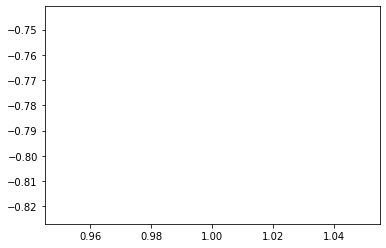

In [18]:
df_plot = df_training.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()

In [19]:
y

0    0.828104
Name: loss, dtype: float64